In [1]:
#import required dependencies here:
import pandas as pd
import datetime

#NOTE: before reading in any .csv files, you need to open the .csv file using a simple text editor and remove the first 
#four lines (starting with '#' symbols) in order to get the csv to load correctly

#read in csv here
AQI_2018_df = pd.read_csv("./Resources/waqi-covid19-airqualitydata-2018H1.csv")

#check output to see if csv loaded into df correctly
AQI_2018_df.head()

Date Country    City Specie  count   min   max  median  variance
0  2018-04-19      HR  Zagreb   pm10     72  12.0  66.0    19.0   1034.64
1  2018-05-03      HR  Zagreb   pm10     72   5.0  46.0    20.0    740.53
2  2018-05-08      HR  Zagreb   pm10     69   7.0  33.0    17.0    286.35
3  2018-05-31      HR  Zagreb   pm10     48  15.0  60.0    25.0    704.61
4  2018-06-22      HR  Zagreb   pm10     62   1.0  60.0     7.0    670.06

In [2]:
#special case for the 2019 datasets - show how to merge two quarters here
#ignore this cell if you have data from any year besides 2019
#note that there are probably ~2 million rows to in the final table, so the operations might take a few seconds

#read in the different quarters - two are shown here
AQI_Info_Q1_2019 = pd.read_csv("./Resources/2019 csvs/waqi-covid19-airqualitydata-2019Q1.csv")
AQI_Info_Q2_2019 = pd.read_csv("./Resources/2019 csvs/waqi-covid19-airqualitydata-2019Q2.csv")

#add the quarters together using pandas' merge operation - outer join
all_quarters_df = AQI_Info_Q1_2019.merge(AQI_Info_Q2_2019, how="outer")

#subsequently merge quarters 3 and 4 into the "all_quarters_df" as shown above, but replacing the "AQI_Info_Q1_2019" df 
#with the "all_quarters_df"

#now check that all the quarters have been joined correctly using an outer join by checking the table length - that is, the 
#total table rows should just be the sum of the rows for each quarter's dataframe, or a merge was performed incorrectly
if(len(all_quarters_df) != (len(AQI_Info_Q1_2019) + len(AQI_Info_Q2_2019))):
    print("Some rows were removed - check your merges!")
else:
    print("The table lengths match, so everything was probably merged correctly!")

The table lengths match, so everything was probably merged correctly!


In [3]:
#group data set by date, and check the date range of the output
#it looks like for 2018 and earlier years the data might only go to the current date (~7/5) because 
#those dates are comparable to the coronavirus shutdown this year
#2019 should have the full range of dates if all quarters are merged correctly
AQI_2018_df.groupby("Date").count()

Country  City  Specie  count   min   max  median  variance
Date                                                                  
2018-01-01     2143  2143    2143   2143  2143  2143    2143      2143
2018-01-02     2202  2202    2202   2202  2202  2202    2202      2202
2018-01-03     2202  2202    2202   2202  2202  2202    2202      2202
2018-01-04     2259  2259    2259   2259  2259  2259    2259      2259
2018-01-05     2270  2270    2270   2270  2270  2270    2270      2270
...             ...   ...     ...    ...   ...   ...     ...       ...
2018-06-27     4878  4878    4878   4878  4878  4878    4878      4878
2018-06-28     4871  4871    4871   4871  4871  4871    4871      4871
2018-06-29     4617  4617    4617   4617  4617  4617    4617      4617
2018-06-30     4497  4497    4497   4497  4497  4497    4497      4497
2018-07-01     4832  4832    4832   4832  4832  4832    4832      4832

[182 rows x 8 columns]

In [20]:
#now that we have checked out the data date ranges, we should narrow the data down to the desired info
#first select by cities that we are interested in
interesting_city_list = ["Los Angeles", "Houston", "Jacksonville", "Manhattan", "Beijing", "Shanghai", "Wuhan", "New Delhi"]
interesting_cities_AQI = AQI_2018_df.loc[AQI_2018_df["City"].isin(interesting_city_list)]

#this should give some idea about how many records there are for each city we are interested in for the year
#the higher the number the more complete the data!
interesting_cities_AQI["City"].value_counts()

Beijing         1593
Shanghai        1362
Jacksonville    1317
Wuhan           1296
Los Angeles     1264
Manhattan       1005
Houston          946
New Delhi        319
Name: City, dtype: int64

In [23]:
#get subsets of o3 and pm2.5 for each city
interesting_cities_o3_2018 = interesting_cities_AQI.loc[interesting_cities_AQI["Specie"] == "o3"]
interesting_cities_pm25_2018 = interesting_cities_AQI.loc[interesting_cities_AQI["Specie"] == "pm25"]

#can check to see if we are missing data for any days for either o3 or pm2.5
print(interesting_cities_o3_2018["City"].value_counts())
print(interesting_cities_pm25_2018["City"].value_counts())

#needed to beef up the AQI conversion table past 500 so that higher AQIs could be converted to concentrations
#used linear regression on the last 50 AQI values (450-500) to extrapolate AQI to concentration conversions for AQI values past 
#500, up to 1000 - but please note that this is an assumption!
print(interesting_cities_pm25_2018["max"].max())

Shanghai        182
Beijing         182
Manhattan       182
Jacksonville    182
Houston         182
Los Angeles     181
Wuhan           166
Name: City, dtype: int64
Los Angeles     182
Shanghai        182
Jacksonville    182
Beijing         182
Manhattan       182
Houston         182
New Delhi       178
Wuhan           166
Name: City, dtype: int64
824.0


In [16]:
#import csv info for conversion table between AQI and pollutant concentrations

pm25_conversion_df = pd.read_csv("./Resources/Conversion CSVs/pm25_conversion.csv")
o3_conversion_df = pd.read_csv("./Resources/Conversion CSVs/o3_conversion.csv")

In [26]:
#conversion from aqi to concentration for pm2.5
#variance omitted because that calculation is not directly proportional to AQI and not that relevant for our project

#function AQI_to_Conc takes an o3 or an pm25 dataframe as an argument
#returns a new dataframe with the min, max, and median values converted to measures with units
#also drops the variance column for the new dataframe returned
def AQI_to_Conc(df):
    #setup dictionary to choose how to convert input data
    types = {"o3":o3_conversion_df, "pm25":pm25_conversion_df}
    
    #picks conversion df dynamically
    pollutant = df["Specie"].iloc[0]
    conversion_df = types[pollutant]
    
    #copy input dataframe -> will be changed by function
    updated_df = df.copy()
    
    #get the units for the concentration measurements
    units = conversion_df.columns[0].replace(pollutant, "")
    
    #add the new columns
    update_columns = ["min", "max", "median"]
    for col in update_columns:
        #note that we need to round the AQI to get an integer for row lookup
        updated_df[col + units] = updated_df[col].apply(lambda x: conversion_df[pollutant + units][round(x)])
    
    #drop the old columns (and "variance")
    updated_df = updated_df.drop(axis=1, columns=(update_columns+["variance"]))

    return updated_df
    
#get new dataframes for the concentrations of the pollutants using the above function
#only takes the dataframe for one pollutant as an argument
interesting_cities_pm25_2018_conc = AQI_to_Conc(interesting_cities_pm25_2018)
interesting_cities_o3_2018_conc = AQI_to_Conc(interesting_cities_o3_2018)

print(interesting_cities_pm25_2018_conc.head())
interesting_cities_o3_2018_conc.head()


              Date Country     City Specie  count  min (ug/m3)  max (ug/m3)  \
184316  2018-01-26      CN  Beijing   pm25    411          3.1        101.9   
184317  2018-02-15      CN  Beijing   pm25    447          3.1        427.7   
184318  2018-05-31      CN  Beijing   pm25    475          3.1        121.3   
184319  2018-06-14      CN  Beijing   pm25    464          3.1        109.7   
184320  2018-06-18      CN  Beijing   pm25    469          7.2        144.5   

        median (ug/m3)  
184316            29.2  
184317            21.1  
184318            30.1  
184319            22.0  
184320            78.7  


Date Country     City Specie  count  min (ppb)  max (ppb)  \
184134  2018-04-02      CN  Beijing     o3    442        1.0       73.0   
184135  2018-06-23      CN  Beijing     o3    451        1.0       89.0   
184136  2018-06-28      CN  Beijing     o3    448        1.0       61.0   
184137  2018-01-06      CN  Beijing     o3    426        1.0       28.0   
184138  2018-02-01      CN  Beijing     o3    375        1.0       37.0   

        median (ppb)  
184134          31.0  
184135          63.0  
184136          32.0  
184137          14.0  
184138          17.0

In [101]:
#output the pm25 concentration data for our cities for the year 2018
interesting_cities_pm25_2018_conc.to_csv("./Resources/2018 Cleaned/our_cities_pm25_2018.csv", index=False)

#output the o3 concentration data for our cities for the year 2018
interesting_cities_o3_2018_conc.to_csv("./Resources/2018 Cleaned/our_cities_o3_2018.csv", index=False)

## Stopping Point

After you have generated the dataframes that contain the concentrations for each pollutant for the cities we are looking at, and exported the CSVs for those two pollutants for those cities for your year, you are done with this first part of the project. We will need to combine the data from the first 3 years into a larger, aggregate dataframe. From this dataframe we can break down the data by month and then calculate values for each year or all three years combined.

In [61]:
#select by for a certain city, in this case we are doing Wuhan
wuhan_2018_pm25 = interesting_cities_pm25_2018_conc.loc[interesting_cities_pm25_2018_conc["City"] == "Wuhan"]
wuhan_2018_pm25.head()

Date Country   City Specie  count  min (ug/m3)  max (ug/m3)  \
227431  2018-01-29      CN  Wuhan   pm25    301         37.9        119.4   
227432  2018-02-03      CN  Wuhan   pm25    400         11.0         52.1   
227433  2018-04-07      CN  Wuhan   pm25    406          5.0         92.2   
227434  2018-05-08      CN  Wuhan   pm25    402          4.0         46.8   
227435  2018-05-09      CN  Wuhan   pm25    368         10.0         70.9   

        median (ug/m3)  
227431            72.9  
227432            25.8  
227433            23.9  
227434            21.1  
227435            32.0

In [62]:
#convert "Date" column values to datetime objects
wuhan_2018_pm25["Date"] = pd.to_datetime(wuhan_2018_pm25["Date"])

#re-index by date
wuhan_2018_pm25 = wuhan_2018_pm25.set_index("Date")
wuhan_2018_pm25

C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Country   City Specie  count  min (ug/m3)  max (ug/m3)  \
Date                                                                
2018-01-29      CN  Wuhan   pm25    301         37.9        119.4   
2018-02-03      CN  Wuhan   pm25    400         11.0         52.1   
2018-04-07      CN  Wuhan   pm25    406          5.0         92.2   
2018-05-08      CN  Wuhan   pm25    402          4.0         46.8   
2018-05-09      CN  Wuhan   pm25    368         10.0         70.9   
...            ...    ...    ...    ...          ...          ...   
2018-02-08      CN  Wuhan   pm25    406         41.9        151.5   
2018-06-26      CN  Wuhan   pm25    386          2.1         44.8   
2018-01-25      CN  Wuhan   pm25    391         14.0         54.9   
2018-03-22      CN  Wuhan   pm25    404         24.9        146.5   
2018-03-30      CN  Wuhan   pm25    405         40.7        146.5   

            median (ug/m3)  
Date                        
2018-01-29            72.9  
2018-02-03            25.8  
2018-04-07            23.9  
2018-05-08            21.1  
2018-05-09            32.0  
...                    ...  
2018-02-08            78.7  
2018-06-26            14.9  
2018-01-25            32.0  
2018-03-22            54.1  
2018-03-30            80.6  

[166 rows x 7 columns]

In [63]:
#example of getting data for a month
wuhan_jan_2018_pm25 = wuhan_2018_pm25.loc[wuhan_2018_pm25.index.month == 1]
wuhan_jan_2018_pm25

Country   City Specie  count  min (ug/m3)  max (ug/m3)  \
Date                                                                
2018-01-29      CN  Wuhan   pm25    301         37.9        119.4   
2018-01-19      CN  Wuhan   pm25    405         78.7        217.1   
2018-01-23      CN  Wuhan   pm25    400         63.2        159.5   
2018-01-26      CN  Wuhan   pm25    369         15.9         67.1   
2018-01-20      CN  Wuhan   pm25    306         46.8        230.2   
2018-01-30      CN  Wuhan   pm25    403         22.0        165.6   
2018-01-18      CN  Wuhan   pm25    396          2.1        214.0   
2018-01-28      CN  Wuhan   pm25    406         29.2         82.6   
2018-01-16      CN  Wuhan   pm25    297         52.1        183.8   
2018-01-22      CN  Wuhan   pm25    402         26.8        150.4   
2018-01-27      CN  Wuhan   pm25    378         24.9         70.9   
2018-01-21      CN  Wuhan   pm25    385         32.0        227.1   
2018-01-24      CN  Wuhan   pm25    391         16.8        111.6   
2018-01-17      CN  Wuhan   pm25    400         34.9        187.8   
2018-01-31      CN  Wuhan   pm25    406         29.2        121.3   
2018-01-25      CN  Wuhan   pm25    391         14.0         54.9   

            median (ug/m3)  
Date                        
2018-01-29            72.9  
2018-01-19           140.7  
2018-01-23           103.9  
2018-01-26            34.9  
2018-01-20           151.5  
2018-01-30            67.1  
2018-01-18           127.1  
2018-01-28            52.1  
2018-01-16           113.6  
2018-01-22            74.8  
2018-01-27            46.8  
2018-01-21           121.3  
2018-01-24            46.0  
2018-01-17            98.1  
2018-01-31            59.3  
2018-01-25            32.0

In [64]:
#can get summary stats for a month as follows

#can look at averages of medians, median of medians, average maximum for the month, maximum values for each month overall, etc.
#can also write a function later to do this for each month and output the relevant statistics to a dataframe
wuhan_jan_2018_pm25.describe()

count  min (ug/m3)  max (ug/m3)  median (ug/m3)
count   16.000000    16.000000    16.000000       16.000000
mean   377.250000    32.906250   147.706250       83.881250
std     39.092199    19.508715    59.858906       38.776801
min    297.000000     2.100000    54.900000       32.000000
25%    375.750000    20.700000   104.350000       50.775000
50%    393.500000    29.200000   154.950000       73.850000
75%    402.250000    40.125000   194.350000      115.525000
max    406.000000    78.700000   230.200000      151.500000

Country   City Specie  count  min (ug/m3)  max (ug/m3)  \
Date                                                                
2018-01-16      CN  Wuhan   pm25    297         52.1        183.8   
2018-01-17      CN  Wuhan   pm25    400         34.9        187.8   
2018-01-18      CN  Wuhan   pm25    396          2.1        214.0   
2018-01-19      CN  Wuhan   pm25    405         78.7        217.1   
2018-01-20      CN  Wuhan   pm25    306         46.8        230.2   
...            ...    ...    ...    ...          ...          ...   
2018-06-27      CN  Wuhan   pm25    368          2.1         52.1   
2018-06-28      CN  Wuhan   pm25    383          3.1         57.4   
2018-06-29      CN  Wuhan   pm25    398          5.0         67.1   
2018-06-30      CN  Wuhan   pm25    405          1.2         65.1   
2018-07-01      CN  Wuhan   pm25    401          1.2         48.9   

            median (ug/m3)  
Date                        
2018-01-16           113.6  
2018-01-17            98.1  
2018-01-18           127.1  
2018-01-19           140.7  
2018-01-20           151.5  
...                    ...  
2018-06-27            16.8  
2018-06-28            17.8  
2018-06-29            29.2  
2018-06-30            21.1  
2018-07-01            21.1  

[166 rows x 7 columns]

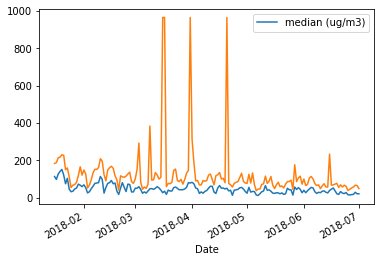

In [74]:
#example line plot for wuhan for overall time period of 2018 for pm2.5

#first plot median line graph
example_plot = wuhan_2018_pm25.plot(kind="line", y="median (ug/m3)")

#sort the values by date
wuhan_2018_pm25 = wuhan_2018_pm25.sort_values(by="Date")

#then plot the max line graph on the same plot
example_plot.plot(wuhan_2018_pm25.index, wuhan_2018_pm25["max (ug/m3)"])
wuhan_2018_pm25

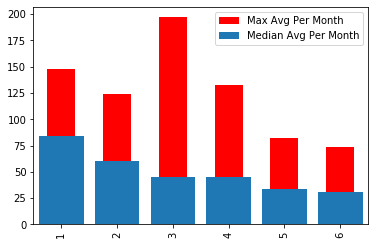

In [98]:
#example bar graph
averages_per_month = []
max_averages_per_month = []
months = []
for m in range(1, 7):
    months.append(m)
    curr_month_wuhan = wuhan_2018_pm25.loc[wuhan_2018_pm25.index.month == m]
    averages_per_month.append(curr_month_wuhan["median (ug/m3)"].mean())
    max_averages_per_month.append(curr_month_wuhan["max (ug/m3)"].mean())
    
bar_chart_df = pd.DataFrame({"Median Average per Month Wuhan 2018":averages_per_month, 
                             "Max Avg Per Month":max_averages_per_month}, index=months)
bar_axes = bar_chart_df.plot(kind="bar", y="Max Avg Per Month", color="r")
bar_axes.bar([a-1 for a in months], bar_chart_df["Median Average per Month Wuhan 2018"], label="Median Avg Per Month")
bar_axes.legend(loc="best")

I wanted to do the shutdown times vs. previous years by month on a chart like the one above for some measure of center to get the percentage pollution decrease